In [ ]:
 # Cell 0 — Imports & settings
import numpy as np
import pandas as pd
import math
import pickle
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [ ]:
# Cell 1 — Load CSV (set your path)
CSV_PATH = "/content/drive/MyDrive/dataset/data_one.csv"   # <- replace with your file path

df = pd.read_csv(CSV_PATH, parse_dates=['acq_date'])
print("Rows, Columns:", df.shape)
display(df.head())
print("\nColumn datatypes:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isna().sum())


Rows, Columns: (12192, 10)


,latitude,longitude,acq_date,fire_occurred,temperature,humidity,wind_speed,precipitation,elevation,vpd
0,27.061320,82.168523,2018-03-18,0,25.62,16.21,2.58,0.00,101.0,2.754
1,26.675432,84.513560,2022-04-25,0,32.94,17.47,3.49,0.00,78.0,4.137
2,27.510031,85.351383,2017-04-03,0,21.53,35.35,1.83,1.80,1538.0,1.661
3,26.986483,88.207364,2021-03-22,0,19.26,34.22,1.76,0.01,1374.0,1.469
4,27.644770,83.815900,2017-04-27,1,31.61,22.37,2.41,0.03,355.0,3.611



Column datatypes:
latitude                float64
longitude               float64
acq_date         datetime64[ns]
fire_occurred             int64
temperature             float64
humidity                float64
wind_speed              float64
precipitation           float64
elevation               float64
vpd                     float64
dtype: object

Missing values per column:
latitude          0
longitude         0
acq_date          0
fire_occurred     0
temperature       0
humidity          0
wind_speed        0
precipitation     0
elevation        23
vpd               0
dtype: int64


In [ ]:
# ===== After Step 1: we found missing values =====
# Show count of missing values (for quick visibility)
print("Missing counts before imputation:")
print(df.isna().sum())

# Choose numeric columns to median-impute (including 'elevation')
numeric_cols = ['latitude','longitude','temperature','humidity','wind_speed',
                'precipitation','elevation','vpd']  # include vpd if present (we compute later if not)

# Compute medians from the full dataframe (or you may prefer from train set later)
medians = df[numeric_cols].median()
print("\nComputed medians (used for imputation):")
print(medians)

# Apply median imputation (replace NaNs in those numeric columns)
df[numeric_cols] = df[numeric_cols].fillna(medians)

# Verify missing values are handled
print("\nMissing counts AFTER median imputation:")
print(df[numeric_cols].isna().sum())

# If you also have missing values in month/day or other derived cols, handle them similarly.
# Save medians for later use (so preprocessing uses identical values when serving model)
medians_dict = medians.to_dict()
# Optionally persist medians to disk for model-serving
import json
with open("imputation_medians.json", "w") as f:
    json.dump(medians_dict, f)
print("\nSaved imputation medians to imputation_medians.json")


Missing counts before imputation:
latitude          0
longitude         0
acq_date          0
fire_occurred     0
temperature       0
humidity          0
wind_speed        0
precipitation     0
elevation        23
vpd               0
dtype: int64

Computed medians (used for imputation):
latitude          28.200
longitude         83.800
temperature       21.600
humidity          38.770
wind_speed         1.950
precipitation      0.000
elevation        982.000
vpd                1.245
dtype: float64

Missing counts AFTER median imputation:
latitude         0
longitude        0
temperature      0
humidity         0
wind_speed       0
precipitation    0
elevation        0
vpd              0
dtype: int64

Saved imputation medians to imputation_medians.json


Target distribution (fire_occurred):
fire_occurred
0    0.500164
1    0.499836
Name: proportion, dtype: float64

Feature summary (numeric):


,count,mean,min,25%,50%,75%,max,std
latitude,12192.0,28.244738,26.3,27.4,28.2,29.0,30.5,1.027789
longitude,12192.0,83.999573,80.0,81.8,83.8,86.0,89.5,2.552396
acq_date,12192,2019-05-02 21:27:45.354330624,2012-01-01 00:00:00,2016-04-10 00:00:00,2019-05-09 00:00:00,2022-08-08 06:00:00,2025-06-20 00:00:00,NaN
fire_occurred,12192.0,0.499836,0.0,0.0,0.0,1.0,1.0,0.50002
temperature,12192.0,16.963796,-25.3,7.34,21.6,27.17,40.64,13.213807
humidity,12192.0,45.076372,5.96,25.0675,38.77,64.8,99.93,23.57757
wind_speed,12192.0,2.168711,0.18,1.59,1.95,2.56,9.5,0.90682
precipitation,12192.0,1.48446,0.0,0.0,0.0,0.42,165.52,5.45735
elevation,12192.0,1824.539042,43.0,256.0,982.0,3334.0,7281.0,1905.757833
vpd,12192.0,1.533446,0.0,0.317,1.245,2.53,6.562,1.276443


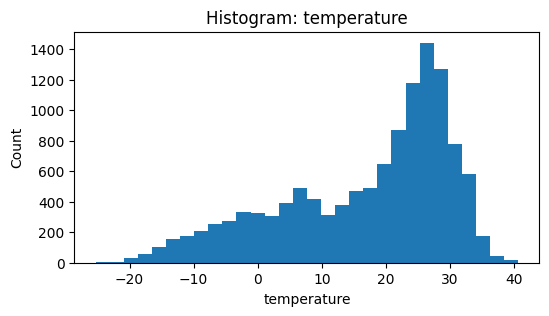

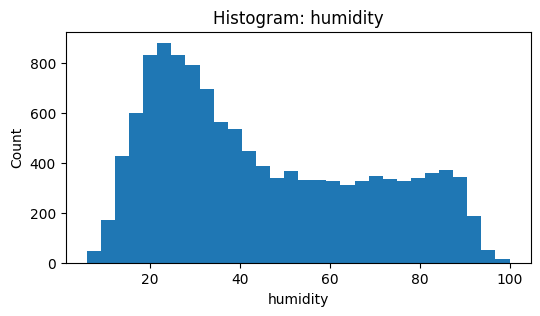

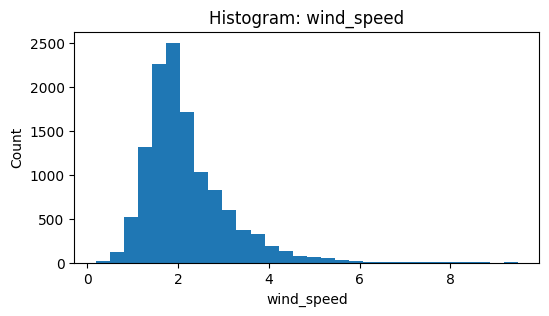

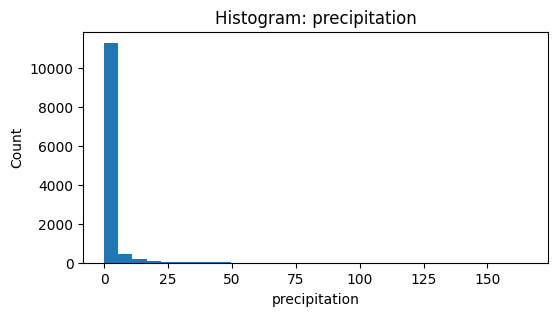

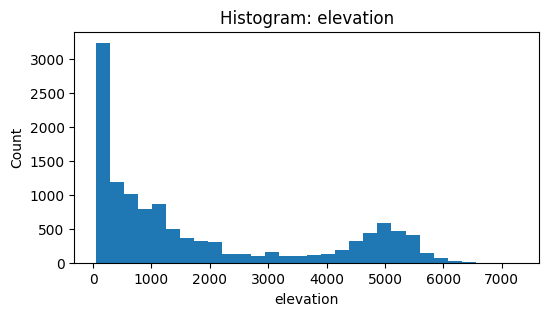

In [ ]:
# Cell 2 — EDA: class balance and feature summaries
print("Target distribution (fire_occurred):")
print(df['fire_occurred'].value_counts(normalize=True))

print("\nFeature summary (numeric):")
display(df.describe().T)

# Plot simple histograms for a few key features
features_to_plot = ['temperature','humidity','wind_speed','precipitation','elevation']
for f in features_to_plot:
    plt.figure(figsize=(6,3))
    plt.hist(df[f].dropna(), bins=30)
    plt.title(f"Histogram: {f}")
    plt.xlabel(f)
    plt.ylabel("Count")
    plt.show()


Target distribution (fire_occurred):
fire_occurred
0    0.500164
1    0.499836
Name: proportion, dtype: float64

Feature summary (numeric):


,count,mean,min,25%,50%,75%,max,std
latitude,12192.0,28.244738,26.3,27.4,28.2,29.0,30.5,1.027789
longitude,12192.0,83.999573,80.0,81.8,83.8,86.0,89.5,2.552396
acq_date,12192,2019-05-02 21:27:45.354330624,2012-01-01 00:00:00,2016-04-10 00:00:00,2019-05-09 00:00:00,2022-08-08 06:00:00,2025-06-20 00:00:00,NaN
fire_occurred,12192.0,0.499836,0.0,0.0,0.0,1.0,1.0,0.50002
temperature,12192.0,16.963796,-25.3,7.34,21.6,27.17,40.64,13.213807
humidity,12192.0,45.076372,5.96,25.0675,38.77,64.8,99.93,23.57757
wind_speed,12192.0,2.168711,0.18,1.59,1.95,2.56,9.5,0.90682
precipitation,12192.0,1.48446,0.0,0.0,0.0,0.42,165.52,5.45735
elevation,12192.0,1824.539042,43.0,256.0,982.0,3334.0,7281.0,1905.757833
vpd,12192.0,1.533446,0.0,0.317,1.245,2.53,6.562,1.276443


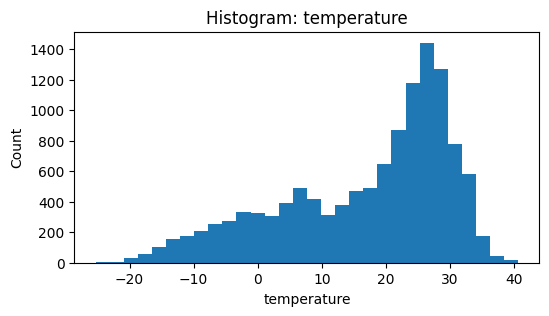

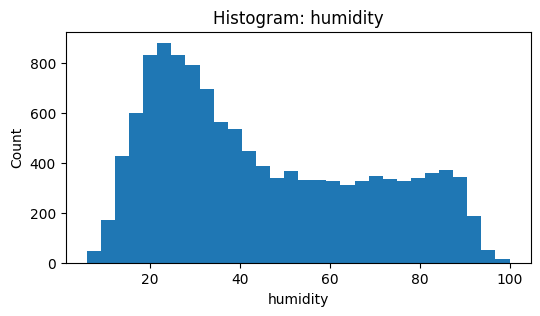

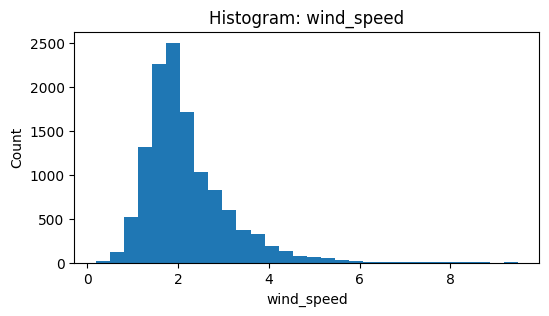

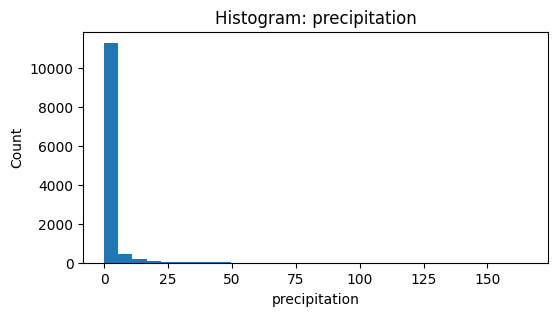

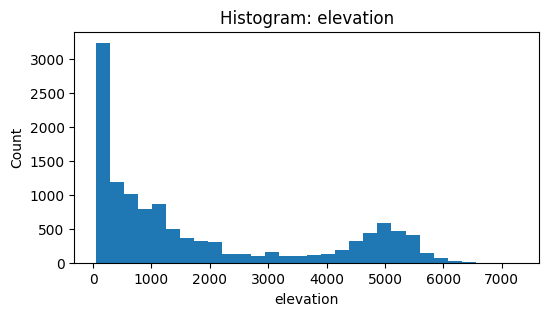

In [ ]:
# Cell 2 — EDA: class balance and feature summaries
print("Target distribution (fire_occurred):")
print(df['fire_occurred'].value_counts(normalize=True))

print("\nFeature summary (numeric):")
display(df.describe().T)

# Plot simple histograms for a few key features
features_to_plot = ['temperature','humidity','wind_speed','precipitation','elevation']
for f in features_to_plot:
    plt.figure(figsize=(6,3))
    plt.hist(df[f].dropna(), bins=30)
    plt.title(f"Histogram: {f}")
    plt.xlabel(f)
    plt.ylabel("Count")
    plt.show()


In [ ]:
# Cell 3 — Preprocessing functions (mean impute + VPD calc)
def calculate_vpd(temp_c, humidity):
    # saturation vapour pressure (kPa)
    es = 0.6108 * np.exp((17.27 * temp_c) / (temp_c + 237.3))
    ea = es * (humidity / 100.0)
    vpd = es - ea
    return vpd

# Add temporal features and VPD if needed, then mean-impute
def preprocess_dataframe(df):
    df = df.copy()
    # Ensure target type
    df['fire_occurred'] = df['fire_occurred'].astype(int)
    # temporal
    if 'acq_date' in df.columns:
        df['month'] = df['acq_date'].dt.month
        df['day_of_year'] = df['acq_date'].dt.dayofyear
        df = df.drop(columns=['acq_date'])
    # VPD
    if 'vpd' not in df.columns or df['vpd'].isna().any():
        # vectorized apply
        df['vpd'] = calculate_vpd(df['temperature'].values, df['humidity'].values)
    # selected features (order important)
    feature_cols = [
        'latitude','longitude',
        'temperature','humidity','wind_speed','precipitation',
        'elevation','vpd','month','day_of_year'
    ]
    X = df[feature_cols].copy()
    # mean imputation (requested)
    medians = X.median()  # Calculate median of each column
    X = X.fillna(medians)  # Fill missing values with respective column medians
    y = df['fire_occurred'].copy()
    return X, y, medians, feature_cols

X_df, y_series, means, feature_cols = preprocess_dataframe(df)
print("Features after preprocessing (first 5 rows):")
display(X_df.head())
print("Saved column median (for later impute):")
print(means)


Features after preprocessing (first 5 rows):


,latitude,longitude,temperature,humidity,wind_speed,precipitation,elevation,vpd,month,day_of_year
0,27.061320,82.168523,25.62,16.21,2.58,0.00,101.0,2.754,3,77
1,26.675432,84.513560,32.94,17.47,3.49,0.00,78.0,4.137,4,115
2,27.510031,85.351383,21.53,35.35,1.83,1.80,1538.0,1.661,4,93
3,26.986483,88.207364,19.26,34.22,1.76,0.01,1374.0,1.469,3,81
4,27.644770,83.815900,31.61,22.37,2.41,0.03,355.0,3.611,4,117


Saved column median (for later impute):
latitude          28.200
longitude         83.800
temperature       21.600
humidity          38.770
wind_speed         1.950
precipitation      0.000
elevation        982.000
vpd                1.245
month              4.000
day_of_year      114.000
dtype: float64


In [ ]:
# Cell 4 — Stratified split (80/20)
def stratified_train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE):
    np.random.seed(random_state)
    indices = np.arange(len(y))
    classes = y.values
    train_idx, test_idx = [], []
    for cls in np.unique(classes):
        cls_idx = indices[classes == cls]
        np.random.shuffle(cls_idx)
        n_test = int(len(cls_idx) * test_size)
        test_idx.extend(cls_idx[:n_test])
        train_idx.extend(cls_idx[n_test:])
    train_idx, test_idx = np.array(train_idx), np.array(test_idx)
    return X.values[train_idx], X.values[test_idx], y.values[train_idx], y.values[test_idx]

X_train, X_test, y_train, y_test = stratified_train_test_split(X_df, y_series, test_size=0.2)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train positive ratio:", y_train.mean(), "Test positive ratio:", y_test.mean())


Train shape: (9755, 10) Test shape: (2437, 10)
Train positive ratio: 0.4998462327011789 Test positive ratio: 0.4997948297086582


In [ ]:
# Cell 5 — Decision Tree & Random Forest implementation (from scratch)
from collections import Counter

def gini(y):
    if len(y) == 0: return 0.0
    counts = Counter(y)
    n = len(y)
    return 1.0 - sum((counts[c] / n)**2 for c in counts)

def best_split_for_column(X_col, y):
    n = len(y)
    if n <= 1: return None, 0.0, None
    order = np.argsort(X_col)
    Xs, ys = X_col[order], y[order]
    parent_gini = gini(ys)
    best_gain = 0.0
    best_t = None
    best_mask = None
    cum_pos = np.cumsum(ys == 1)
    for i in range(n-1):
        if Xs[i] == Xs[i+1]:
            continue
        left_n = i+1
        right_n = n - left_n
        left_pos = cum_pos[i]
        right_pos = cum_pos[-1] - left_pos
        left_gini = 1 - (left_pos/left_n)**2 - ((left_n - left_pos)/left_n)**2
        right_gini = 1 - (right_pos/right_n)**2 - ((right_n - right_pos)/right_n)**2
        weighted = (left_n/n)*left_gini + (right_n/n)*right_gini
        gain = parent_gini - weighted
        if gain > best_gain:
            best_gain = gain
            best_t = (Xs[i] + Xs[i+1]) / 2.0
            best_mask = X_col <= best_t
    return best_t, best_gain, best_mask

class TreeNode:
    def __init__(self):
        self.is_leaf=False
        self.pred=None
        self.probs=None
        self.feature_idx=None
        self.threshold=None
        self.left=None
        self.right=None

class DecisionTreeFromScratch:
    def __init__(self, max_depth=8, min_samples_split=4, max_features=None, rng=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.rng = rng if rng is not None else np.random.RandomState()
        self.feature_importances_ = defaultdict(float)  # sum of gains per feature

    def fit(self, X, y):
        self.n_features_ = X.shape[1]
        if self.max_features is None:
            self.max_features = max(1, int(np.sqrt(self.n_features_)))
        self.root = self._build(X, y, depth=0)

    def _build(self, X, y, depth):
        node = TreeNode()
        n = len(y)
        counts = Counter(y)
        node.probs = np.array([counts.get(0,0)/n, counts.get(1,0)/n])
        node.pred = 1 if node.probs[1] >= node.probs[0] else 0

        if depth >= self.max_depth or n < self.min_samples_split or gini(y) == 0:
            node.is_leaf = True
            return node

        feat_idxs = self.rng.choice(self.n_features_, self.max_features, replace=False)
        best_gain = 0.0
        best_feat = None
        best_thresh = None
        best_mask = None

        for f in feat_idxs:
            t, gain, mask = best_split_for_column(X[:, f], y)
            if gain is not None and gain > best_gain:
                best_gain, best_feat, best_thresh, best_mask = gain, f, t, mask

        if best_feat is None:
            node.is_leaf = True
            return node

        # record gain for feature importance
        self.feature_importances_[best_feat] += best_gain

        node.feature_idx = best_feat
        node.threshold = best_thresh
        left_mask = best_mask
        right_mask = ~best_mask
        node.left = self._build(X[left_mask], y[left_mask], depth+1)
        node.right = self._build(X[right_mask], y[right_mask], depth+1)
        return node

    def _predict_one(self, node, x):
        if node.is_leaf:
            return node.pred, node.probs
        if x[node.feature_idx] <= node.threshold:
            return self._predict_one(node.left, x)
        else:
            return self._predict_one(node.right, x)

    def predict_proba(self, X):
        return np.array([self._predict_one(self.root, row)[1] for row in X])

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)[:,1]
        return (probs >= threshold).astype(int)

class RandomForestFromScratch:
    def __init__(self, n_estimators=50, max_depth=8, min_samples_split=4, max_features=None, random_state=RANDOM_STATE):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.rng = np.random.RandomState(random_state)
        self.trees = []
        self.feature_importances_ = None

    def fit(self, X, y):
        n = X.shape[0]
        if self.max_features is None:
            self.max_features = max(1, int(np.sqrt(X.shape[1])))
        self.trees = []
        importances = []
        for i in range(self.n_estimators):
            idxs = self.rng.choice(n, n, replace=True)
            Xb, yb = X[idxs], y[idxs]
            tree_rng = np.random.RandomState(self.rng.randint(0, 1_000_000_000))
            tree = DecisionTreeFromScratch(max_depth=self.max_depth, min_samples_split=self.min_samples_split, max_features=self.max_features, rng=tree_rng)
            tree.fit(Xb, yb)
            self.trees.append(tree)
            # collect tree-level feature importances
            arr = np.zeros(X.shape[1])
            for k,v in tree.feature_importances_.items():
                arr[k] = v
            importances.append(arr)
        # average importances across trees
        self.feature_importances_ = np.mean(np.vstack(importances), axis=0)

    def predict_proba(self, X):
        probs = np.zeros((X.shape[0], 2))
        for tree in self.trees:
            probs += tree.predict_proba(X)
        probs /= len(self.trees)
        return probs

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)[:,1]
        return (proba >= threshold).astype(int)


In [ ]:
# Cell 6 — Train
rf = RandomForestFromScratch(n_estimators=100, max_depth=10, min_samples_split=12)
print("Training Random Forest (this may take some minutes)...")
rf.fit(X_train, y_train)
print("Training completed.")


Training Random Forest (this may take some minutes)...
Training completed.


Numeric metrics:
{'precision': 0.9107569721108281, 'recall': 0.9384236453194266, 'f1': 0.9243833395721504, 'accuracy': 0.9232663110377828, 'cm': {'tp': 1143, 'tn': 1107, 'fp': 112, 'fn': 75}}


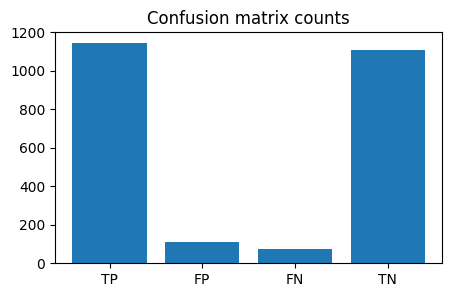

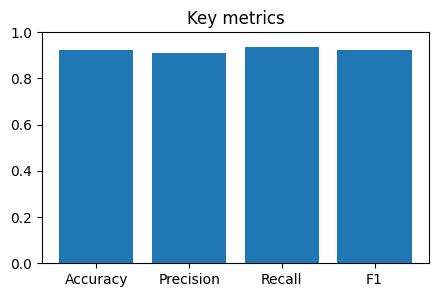

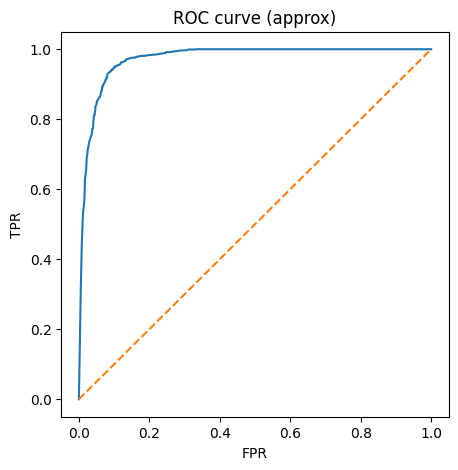

Approx ROC AUC: 0.9726902047612511


/tmp/ipython-input-333827979.py:66: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tprs[np.argsort(fprs)], np.sort(fprs))


In [ ]:
# Cell 7 — Evaluation functions and compute metrics
def confusion_counts(y_true, y_pred):
    tp = int(((y_true==1) & (y_pred==1)).sum())
    tn = int(((y_true==0) & (y_pred==0)).sum())
    fp = int(((y_true==0) & (y_pred==1)).sum())
    fn = int(((y_true==1) & (y_pred==0)).sum())
    return {'tp':tp,'tn':tn,'fp':fp,'fn':fn}

def precision_recall_f1(y_true, y_pred):
    cm = confusion_counts(y_true, y_pred)
    tp,fp,fn = cm['tp'], cm['fp'], cm['fn']
    precision = tp/(tp+fp+1e-9)
    recall = tp/(tp+fn+1e-9)
    f1 = 2*precision*recall/(precision+recall+1e-9)
    accuracy = (cm['tp'] + cm['tn']) / (cm['tp']+cm['tn']+cm['fp']+cm['fn']+1e-9)
    return {'precision':precision,'recall':recall,'f1':f1,'accuracy':accuracy,'cm':cm}

# Predict on test set
y_proba_test = rf.predict_proba(X_test)[:,1]
y_pred_test = (y_proba_test >= 0.5).astype(int)
metrics = precision_recall_f1(y_test, y_pred_test)
print("Numeric metrics:")
print(metrics)

# Confusion matrix bar
cm = metrics['cm']
labels = ['TP','FP','FN','TN']
values = [cm['tp'], cm['fp'], cm['fn'], cm['tn']]
plt.figure(figsize=(5,3))
plt.bar(labels, values)
plt.title("Confusion matrix counts")
plt.show()

# Metric bar chart
plt.figure(figsize=(5,3))
plt.bar(['Accuracy','Precision','Recall','F1'], [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']])
plt.ylim(0,1)
plt.title("Key metrics")
plt.show()

# ROC curve (sweep thresholds)
def roc_curve_points(y_true, y_score, n_steps=200):
    thresholds = np.linspace(0,1,n_steps)
    tprs, fprs = [], []
    P = (y_true==1).sum()
    N = (y_true==0).sum()
    for thr in thresholds:
        y_pred = (y_score >= thr).astype(int)
        cm = confusion_counts(y_true, y_pred)
        tpr = cm['tp']/(P+1e-9)
        fpr = cm['fp']/(N+1e-9)
        tprs.append(tpr)
        fprs.append(fpr)
    return np.array(fprs), np.array(tprs), thresholds

fprs, tprs, thresholds = roc_curve_points(y_test, y_proba_test, n_steps=200)
plt.figure(figsize=(5,5))
plt.plot(fprs, tprs)
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve (approx)")
plt.show()

# approximate AUC
auc = np.trapz(tprs[np.argsort(fprs)], np.sort(fprs))
print("Approx ROC AUC:", auc)


In [ ]:
# Evaluate on train data
y_train_pred = rf.predict(X_train)
train_results = metrics_eval(y_train, y_train_pred)
print("📊 Training Set Metrics:", train_results)

# Evaluate on test data
y_test_pred = rf.predict(X_test)
test_results = metrics_eval(y_test, y_test_pred)
print("📊 Test Set Metrics:", test_results)


📊 Training Set Metrics: {'acc': 0.9730394669399309, 'precision': 0.9546619357380337, 'recall': 0.9932321575059488, 'f1': 0.9735651819303952, 'cm': {'tp': 4843, 'tn': 4649, 'fp': 230, 'fn': 33}}
📊 Test Set Metrics: {'acc': 0.9220352892897324, 'precision': 0.911199999999271, 'recall': 0.9351395730698397, 'f1': 0.9230145862092226, 'cm': {'tp': 1139, 'tn': 1108, 'fp': 111, 'fn': 79}}


Feature importances (approx.):


,0
elevation,4.358637
longitude,4.066409
temperature,3.394373
day_of_year,3.347791
humidity,3.290615
latitude,3.273832
vpd,3.124599
wind_speed,3.034169
precipitation,1.581676
month,0.930075


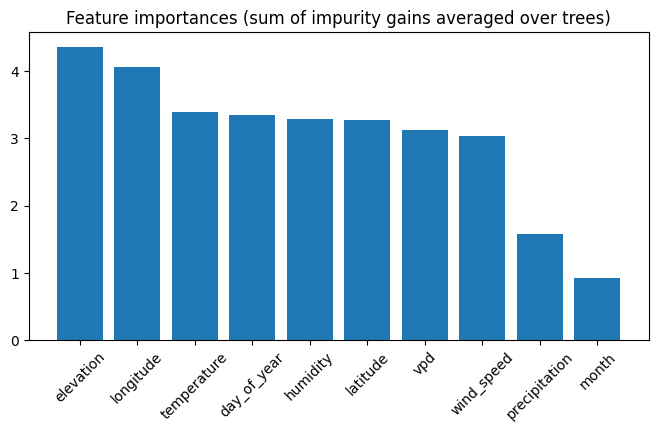

In [ ]:
# Cell 8 — Feature importances
importances = rf.feature_importances_
# map to feature names
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
print("Feature importances (approx.):")
display(feat_imp)
plt.figure(figsize=(8,4))
plt.bar(feat_imp.index, feat_imp.values)
plt.xticks(rotation=45)
plt.title("Feature importances (sum of impurity gains averaged over trees)")
plt.show()


In [ ]:
# Cell 9 — Save model bundle
bundle = {'model': rf, 'feature_cols': feature_cols, 'means': means.to_dict()}
with open("random_forest_from_scratch.pkl", "wb") as f:
    pickle.dump(bundle, f)
print("Saved model to random_forest_from_scratch.pkl")


Saved model to random_forest_from_scratch.pkl


In [ ]:
# Cell 10 — Manual test function (simulate frontend)
def predict_fire_from_bundle(bundle_path, inputs_dict, threshold=0.5):
    with open(bundle_path, "rb") as f:
        bundle = pickle.load(f)
    model = bundle['model']
    cols = bundle['feature_cols']
    means = bundle['means']

    # ensure vpd present (auto-calc if missing)
    if 'vpd' not in inputs_dict or inputs_dict.get('vpd') is None:
        inputs_dict['vpd'] = calculate_vpd(inputs_dict['temperature'], inputs_dict['humidity'])

    # build input vector in correct order; impute missing from means
    x = np.array([[ inputs_dict.get(c, means[c]) for c in cols ]], dtype=float)
    proba = model.predict_proba(x)[0,1]
    pred = int(proba >= threshold)
    if proba < 0.33:
        risk = "Low"
    elif proba < 0.66:
        risk = "Moderate"
    else:
        risk = "High"
    return {'probability': float(proba), 'prediction': pred, 'risk_level': risk}

# Example manual call:
example_input = dict(latitude=27.5, longitude=85.3, temperature=32, humidity=40,
                     wind_speed=3.2, precipitation=0.1, elevation=1200,
                     month=4, day_of_year=120)
result = predict_fire_from_bundle("/content/random_forest_from_scratch.pkl", example_input)
print("Manual test result:")
print(result)


Manual test result:
{'probability': 0.7358834387777987, 'prediction': 1, 'risk_level': 'High'}
